In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import sys
import time
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from skimage.transform import rotate

In [4]:
def getData(file):
	data = pd.read_csv(file, header=None)
	x = data.iloc[:,1:].to_numpy()
	y = data.iloc[:,0].to_numpy()
	y = np.array([int(i) for i in y])
	return x, y
 
def accuracy(y, pred):
  acc = 0
  for i in range(len(y)):
    if pred[i] == y[i]:
      acc += 1
  acc = acc/len(y)
  return acc

def ConfusionMatrix(y, pred, file):
  labels = np.unique(y)
  cm = confusion_matrix(y, pred)

  fig = plt.figure(figsize=(8,8))
  ax = fig.gca()
  _ = sns.heatmap(cm,annot=True,cmap="Blues",xticklabels=labels,yticklabels=labels,fmt='g')
  ax.set_xlabel("Actual Class")
  ax.set_ylabel("Predicted Class")
  plt.title("Confusion Matrix",y=1.08)
  ax.xaxis.tick_top()
  ax.xaxis.set_label_position('top')
  plt.savefig(file)
  plt.show()
  plt.close()

def rotate_image(x):
  rotatedx = np.zeros(x.shape)
  for i in range(x.shape[0]):
    img = x[i].reshape(48, 48)
    rotated = rotate(img, angle=-45, mode='wrap')
    rotatedx[i] = rotated
  return rotatedx

def flip_image(x):
  flippedx = np.zeros(x.shape)
  for i in range(x.shape[0]):
    img = x[i].reshape(48, 48)
    flipped = np.fliplr(img)
    flippedx[i] = flipped
  return flippedx

In [5]:
x_train, y_train = getData('/content/drive/MyDrive/Colab Notebooks/train.csv')
x_test, y_test = getData('/content/drive/MyDrive/Colab Notebooks/public_test.csv')

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(19376, 2304) (19376,)
(6459, 2304) (6459,)


In [6]:
x_train = x_train.reshape(x_train.shape[0], 1, 48, 48)
x_test = x_test.reshape(x_test.shape[0], 1, 48, 48)

tx_train = torch.FloatTensor(x_train.tolist()).cuda()
ty_train = torch.LongTensor(y_train.tolist()).cuda()

tx_test = torch.FloatTensor(x_test.tolist()).cuda()
ty_test = torch.LongTensor(y_test.tolist()).cuda()

print(tx_train.size())
print(ty_train.size())
print(tx_test.size())
print(ty_test.size())

torch.Size([19376, 1, 48, 48])
torch.Size([19376])
torch.Size([6459, 1, 48, 48])
torch.Size([6459])


In [7]:
flipped_xtrain = flip_image(x_train)
rotated_xtrain = rotate_image(x_train)
fx_train = np.concatenate((x_train, flipped_xtrain))
fx_train = np.concatenate((fx_train, rotated_xtrain))
tfx_train = torch.FloatTensor(fx_train.tolist()).cuda()

fy_train = np.concatenate((y_train, y_train))
fy_train = np.concatenate((fy_train, y_train))
tfy_train = torch.LongTensor(fy_train.tolist()).cuda()

print(tfx_train.size())
print(tfy_train.size())

torch.Size([58128, 1, 48, 48])
torch.Size([58128])


In [8]:
cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

class VGG(nn.Module):
    def __init__(self, cfg):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg)
        self.classifier = nn.Linear(512, 7)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

    def predict(self, x):
      num_batches = int(x.shape[0]/100)
      pred = np.array([0.])
      for i in range(num_batches):
        x_batch = x[i*100:(i+1)*100]
        pred = np.concatenate((pred, torch.max(self.forward(x_batch).data, 1)[1].cpu().numpy()))
      pred = np.concatenate((pred, torch.max(self.forward(x[num_batches*100:x.shape[0]]), 1)[1].cpu().numpy()))
      return pred[1:]

    def fit(self, x, y, r, optimizer, loss_func):
      num_batches = int(x.shape[0]/r)
      converged = False
      epochs = 0
      prevloss = 0
      error = 0
      while not converged:
        for i in range(num_batches):
          x_batch = x[i*r:(i+1)*r]
          y_batch = y[i*r:(i+1)*r]
          x_var = Variable(x_batch)
          y_var = Variable(y_batch)
          optimizer.zero_grad()
          out = self.forward(x_var)
          loss = loss_func(out, y_var)
          loss.backward()
          optimizer.step()
        error = abs(prevloss - loss.data)
        prevloss = loss.data
        print('Epoch: {} - Loss: {:.6f} - Error: {:.6f}'.format(epochs, loss.data, error))
        epochs += 1
        del loss
        if epochs > 10 and error < 1e-5 or epochs > 100:
          converged = True

In [9]:
model = VGG(cfg)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

In [10]:
start = time.time()
model.fit(tfx_train, tfy_train, 100, optimizer, loss_func)
end = time.time()
print('Training Time = ', (end-start))

Epoch: 0 - Loss: 1.782794 - Error: 1.782794
Epoch: 1 - Loss: 1.594898 - Error: 0.187896
Epoch: 2 - Loss: 1.395587 - Error: 0.199311
Epoch: 3 - Loss: 1.285332 - Error: 0.110256
Epoch: 4 - Loss: 1.219388 - Error: 0.065944
Epoch: 5 - Loss: 1.159963 - Error: 0.059424
Epoch: 6 - Loss: 0.984645 - Error: 0.175318
Epoch: 7 - Loss: 0.872645 - Error: 0.112000
Epoch: 8 - Loss: 0.828153 - Error: 0.044492
Epoch: 9 - Loss: 0.812816 - Error: 0.015337
Epoch: 10 - Loss: 0.729026 - Error: 0.083790
Epoch: 11 - Loss: 0.592687 - Error: 0.136339
Epoch: 12 - Loss: 0.568213 - Error: 0.024473
Epoch: 13 - Loss: 0.495744 - Error: 0.072469
Epoch: 14 - Loss: 0.600791 - Error: 0.105047
Epoch: 15 - Loss: 0.454253 - Error: 0.146538
Epoch: 16 - Loss: 0.315496 - Error: 0.138757
Epoch: 17 - Loss: 0.394760 - Error: 0.079264
Epoch: 18 - Loss: 0.257567 - Error: 0.137193
Epoch: 19 - Loss: 0.248133 - Error: 0.009433
Epoch: 20 - Loss: 0.316413 - Error: 0.068280
Epoch: 21 - Loss: 0.134539 - Error: 0.181874
Epoch: 22 - Loss: 0.

Train Accuracy =  0.9973162675474814
Macro F1 Score  =  0.9971962198408001


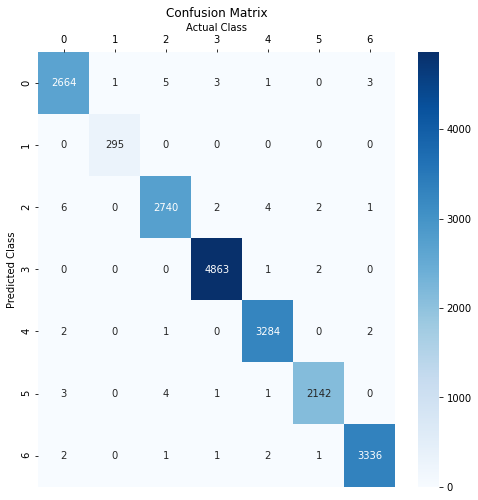

In [11]:
train_pred = model.predict(tx_train)
train_acc = accuracy(y_train, train_pred)
print("Train Accuracy = ", train_acc)
print("Macro F1 Score  = ", f1_score(y_train, train_pred, average='macro'))
ConfusionMatrix(y_train, train_pred, 'Q2train.png')

Test Accuracy =  0.6259482892088558
Macro F1 Score  =  0.5993967189586222


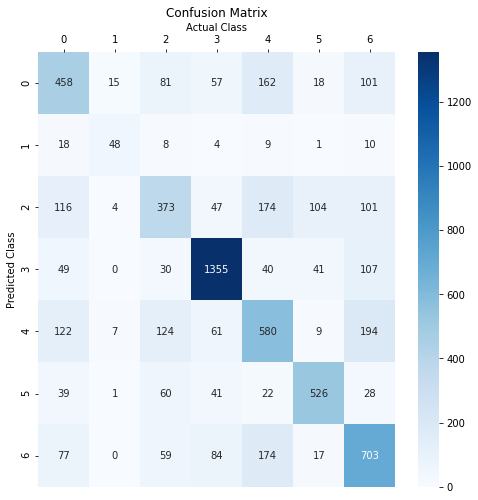

In [12]:
test_pred = model.predict(tx_test)
test_acc = accuracy(y_test, test_pred)
print("Test Accuracy = ", test_acc)
print("Macro F1 Score  = ", f1_score(y_test, test_pred, average='macro'))
ConfusionMatrix(y_test, test_pred, 'Q2test.png')

In [ ]:
 torch.save(model, '/content/drive/MyDrive/Colab Notebooks/Q2')

In [ ]:
! python3 '/content/drive/MyDrive/Colab Notebooks/Q2.py' '/content/drive/MyDrive/Colab Notebooks/train.csv' '/content/drive/MyDrive/Colab Notebooks/private.csv' '/content/drive/MyDrive/Colab Notebooks/A4/Q2.txt'

Epoch: 0 - Loss: 1.638328 - Error: 1.638328
Epoch: 1 - Loss: 1.503321 - Error: 0.135007
Epoch: 2 - Loss: 1.323125 - Error: 0.180196
Epoch: 3 - Loss: 1.252395 - Error: 0.070730
Epoch: 4 - Loss: 1.170606 - Error: 0.081788
Epoch: 5 - Loss: 1.139128 - Error: 0.031478
Epoch: 6 - Loss: 0.946234 - Error: 0.192894
Epoch: 7 - Loss: 0.926162 - Error: 0.020072
Epoch: 8 - Loss: 0.865019 - Error: 0.061143
Epoch: 9 - Loss: 0.748293 - Error: 0.116726
Epoch: 10 - Loss: 0.736292 - Error: 0.012001
Epoch: 11 - Loss: 0.637836 - Error: 0.098456
Epoch: 12 - Loss: 0.609149 - Error: 0.028687
Epoch: 13 - Loss: 0.536512 - Error: 0.072636
Epoch: 14 - Loss: 0.390391 - Error: 0.146122
Epoch: 15 - Loss: 0.427953 - Error: 0.037563
Epoch: 16 - Loss: 0.243680 - Error: 0.184273
Epoch: 17 - Loss: 0.255307 - Error: 0.011627
Epoch: 18 - Loss: 0.150508 - Error: 0.104799
Epoch: 19 - Loss: 0.142261 - Error: 0.008247
Epoch: 20 - Loss: 0.162749 - Error: 0.020488
Epoch: 21 - Loss: 0.120000 - Error: 0.042749
Epoch: 22 - Loss: 0.

In [ ]:
Q2 = torch.load('/content/drive/MyDrive/Colab Notebooks/A4/Q2')

Train Accuracy =  0.9984516928158547
Macro F1 Score =  0.877868767937166


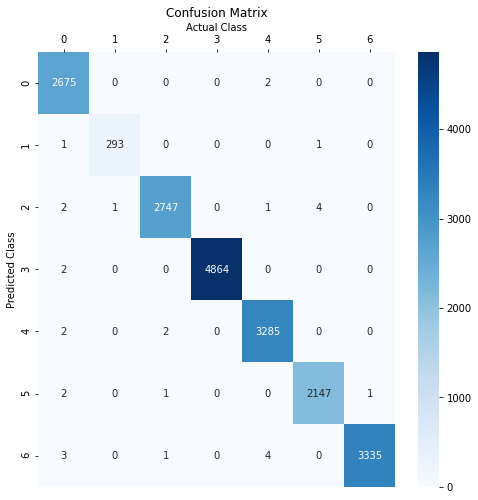

In [ ]:
train_pred = Q2.predict(tx_train)
train_acc = accuracy(y_train, train_pred)
print('Train Accuracy = ', train_acc)
ConfusionMatrix(y_train, train_pred, 'Q2train.png')

Test Accuracy =  0.6310574392320792
Macro F1 Score =  0.822096993407079


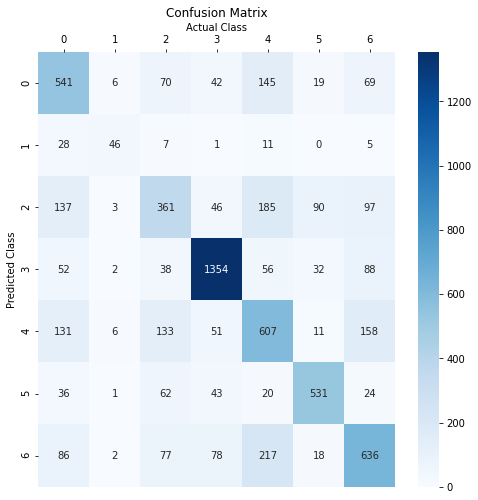

In [ ]:
test_pred = Q2.predict(tx_test)
test_acc = accuracy(y_test, test_pred)
print('Test Accuracy = ', test_acc)
ConfusionMatrix(y_test, test_pred, 'Q2test.png')

In [ ]:
private_xtest, private_ytest = getData('/content/drive/MyDrive/Colab Notebooks/private.csv') 
private_xtest = private_xtest.reshape(private_xtest.shape[0], 1, 48, 48)
print(private_xtest.shape)

(19157, 1, 48, 48)


In [ ]:
private_txtest = torch.FloatTensor(private_xtest.tolist()).cuda()
print(private_txtest.size())

torch.Size([19157, 1, 48, 48])


In [ ]:
private_test_pred = Q2.predict(private_txtest)
print(private_test_pred.shape)

(19157,)


In [ ]:
f = open('/content/drive/MyDrive/Colab Notebooks/Q2.csv', 'w')
print('Id,Prediction', file=f)
for i in range(len(private_test_pred)):
  s = str(i+1) + ',' + str(int(private_test_pred[i]))
  print(s, file=f)
f.close()